In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
import time
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import ast
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [3]:
preproc_files_dir = '/cluster/tufts/hugheslab/prath01/projects/MASTRE/datasets'
static_df = pd.read_csv(os.path.join(preproc_files_dir, 'static_features.csv'))
highfreq_df = pd.read_csv(os.path.join(preproc_files_dir, 'highfreq_features.csv'))
target_outcomes_df = pd.read_csv(os.path.join(preproc_files_dir, 'shot_level_marksmanship_outcomes.csv'))

In [37]:
target_outcomes_df

,subject_uid,target_id,shot_id,mission_phase,aiming_time,shot_x_75,shot_y_75,shot_d_75,shot_x_150,shot_y_150,shot_d_150,shot_x_raw,shot_y_raw,shot_d_raw
0,1001,0-1,0.0,MID,2.565,-228.1,411.8,21.696854,-456.2,823.6,30.683986,-922.0,1664.0,43.616071
1,1001,0-1,2.0,MID,2.730,-173.7,490.5,22.811136,-347.4,981.0,32.259817,-702.0,1982.0,45.854638
2,1001,0-1,4.0,MID,1.200,-211.6,491.0,23.122600,-423.2,982.0,32.700294,-855.0,1984.0,46.479986
3,1001,0-1,6.0,MID,1.320,-147.7,520.2,23.254286,-295.4,1040.4,32.886526,-597.0,2102.0,46.745423
4,1001,0-1,8.0,MID,1.755,-62.8,473.9,21.864193,-125.6,947.8,30.920638,-254.0,1915.0,43.951922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14161,3405,3,61.0,PRE,0.300,39.8,254.1,16.037396,79.6,508.2,22.680303,161.0,1027.0,32.241947
14162,3405,4,62.0,PRE,1.005,37.6,-251.9,15.959033,75.2,-503.8,22.569481,152.0,-1018.0,32.082475
14163,3405,4,63.0,PRE,0.315,-322.7,-177.7,19.193538,-645.4,-355.4,27.143761,-1304.0,-718.0,38.582423
14164,3405,4,64.0,PRE,0.570,66.3,-145.2,12.634104,132.6,-290.4,17.867321,268.0,-587.0,25.402465


## Linear Regression

In [4]:
#------------------------------Multi Train - Test Lasso----------------------------#
def regression_multi_train_test_splits(
        X, y, n_trials, n_cv_folds,
        gridsearchvalues__alpha=np.logspace(-5, 5, 5),
        x_feature_transform='none',
        scoring_metric='mean_squared_error',
        regression_type='lasso'):
    """ Perform nested cross-validation to train Lasso predictor given a fixed training set
    Returns
    -------
    best_regressor_per_trial : list
    perf_dict_per_trial : list
    """
    start_time_sec = time.time()

    print("Fitting Lasso with %d trials of %d-fold nested cross validation" % (
        n_trials, n_cv_folds))

    # Parameter grid to consider on each inner heldout fold
    if isinstance(gridsearchvalues__alpha, str):
        if gridsearchvalues__alpha.count("logspace"):
            gsv = gridsearchvalues__alpha.replace("logspace", "")
            gsv = gsv.replace("(", "")
            gsv = gsv.replace(")", "")
            amin, amax, anum = map(float, gsv.split(','))
            anum = int(anum)
            alpha_grid = np.logspace(amin, amax, anum).astype(np.float64)
        elif gridsearchvalues__alpha.count("linspace"):
            gsv = gridsearchvalues__alpha.replace("linspace", "")
            gsv = gsv.replace("(", "")
            gsv = gsv.replace(")", "")
            amin, amax, anum = map(float, gsv.split(','))
            anum = int(anum)
            alpha_grid = np.linspace(amin, amax, anum).astype(np.float64)
        else:
            alpha_grid = np.asarray(
                list(map(float, gridsearchvalues__alpha.split(","))),
                dtype=np.float64)
    else:
        alpha_grid = np.asarray(gridsearchvalues__alpha, dtype=np.float64)
    alpha_str = ','.join(['%.3g' % a for a in alpha_grid[:3]])
    if alpha_grid.size > 5:
        alpha_str += ',' + '...'
    if alpha_grid.size > 3:
        M = np.maximum(3, alpha_grid.size - 2)
        alpha_str += ',' + ','.join(['%.3g' % a for a in alpha_grid[M:]])
    print("Selecting parameter 'alpha' based on grid search over %d param values:\n%s" % (
        alpha_grid.size, alpha_str))
    param_grid = [{'regressor__alpha': alpha_grid}]
    
    # Arrays to store scores
    best_regressors = [None for _ in range(n_trials)]
    outer_perf_dict_list = [None for _ in range(n_trials)]
    inner_perf_df_list = [None for _ in range(n_trials)]
    
    # Loop for each trial
    for i in range(n_trials):
      
        # Perform OUTER train-test split
        # If we use a test size of 1/(K+1)
        # Then we'll get heldout folds of the same size as the inner heldout folds with K-fold CV
        # Why?
        # Outer fold takes 1/(K+1) of N examples
        # Inner fold takes 1/K of ( K/(K+1) * N ) examples = 1/(K+1) * N
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1.0/(1+n_cv_folds)), random_state=i)  

        # create a cv splitter object 
        inner_cv_splitter = KFold(n_splits=n_cv_folds, shuffle=True, random_state=i)
        
        # STEP 1 in pipeline: 
        step_list = list()
        if x_feature_transform.startswith('standardize'):
            ## Scale the input features to have zero mean/unit variance
            scaler_x = StandardScaler()
            step_list.append(('standardize', scaler_x))
        elif x_feature_transform == 'scale_0_to_1':
            ## Scale the input features to have min zero and max one
            scaler_x = MaxAbsScaler()
            step_list.append(('scale_0_to_1', scaler_x))
        elif x_feature_transform == 'none':
            pass
        else:
            raise ValueError("Unrecognized value: 'x_feature_transform'=%s" % x_feature_transform)
        
        # STEP 2 in pipeline: Define the predictor from input to output
        if regression_type=='lasso':
            step_list.append(('regressor', Lasso(max_iter=10000000, tol=0.001, selection='cyclic')))
        elif regression_type=='ridge':
            step_list.append(('regressor', Ridge(max_iter=10000000, tol=0.001)))

        ## Create Pipeline regressor as composition of steps
        prediction_pipeline = Pipeline(step_list)

        ## Prepare for n-fold cross validation
        if scoring_metric == 'mean_absolute_error':
            scoring = 'neg_mean_absolute_error'
            baseline_func = np.median
        elif scoring_metric == 'mean_squared_error':
            scoring = 'neg_mean_squared_error'
            baseline_func = np.mean
        else:
            raise ValueError("Unrecognized value: 'scoring_metric'=%s" % scoring_metric)

        regressor_with_grid_search = GridSearchCV(
                prediction_pipeline, param_grid,
                cv=inner_cv_splitter,
                scoring=scoring,
                return_train_score=True,
                iid=False, refit=True)
        regressor_with_grid_search.fit(X_train, y_train)

        best_i = regressor_with_grid_search.best_index_
        inner_cv_df = pd.DataFrame(regressor_with_grid_search.cv_results_)
        perf_at_best_df = inner_cv_df.iloc[best_i:(best_i+1)].copy()

        best_regressors[i] = regressor_with_grid_search.best_estimator_
        outer_train_score = regressor_with_grid_search.score(X_train, y_train)
        outer_test_score = regressor_with_grid_search.score(X_test, y_test)
        cur_perf = OrderedDict()
        cur_perf['trial_id'] = i
        for mname, metric_func in [
                ('mse', mean_squared_error),
                ('mae', mean_absolute_error)
                ]:
            yhat_train = best_regressors[i].predict(X_train)
            yhat_test = best_regressors[i].predict(X_test)
            cur_perf['train_%s' % mname] = metric_func(y_train, yhat_train)
            cur_perf['test_%s' % mname] = metric_func(y_test, yhat_test)
        cur_perf['train_size'] = y_train.size
        cur_perf['test_size'] = y_test.size

        cur_perf['outer_train_score'] = -1 * outer_train_score
        cur_perf['outer_test_score'] = -1 * outer_test_score
        cur_perf['inner_mean_train_score'] = -1 * perf_at_best_df['mean_train_score'].values[0]
        cur_perf['inner_mean_test_score'] = -1 * perf_at_best_df['mean_test_score'].values[0]
        tr_vals = np.zeros(n_cv_folds)
        te_vals = np.zeros(n_cv_folds)
        for ss in range(n_cv_folds):
            key = 'split%d' % ss
            tr_vals[ss] = -1 * perf_at_best_df['%s_train_score' % key].values[0]
            te_vals[ss] = -1 * perf_at_best_df['%s_test_score' % key].values[0]
            cur_perf['inner_%s_train_score' % key] = tr_vals[ss]
            cur_perf['inner_%s_test_score' % key] = te_vals[ss]
        for fname, func in [('min', np.min), ('max', np.max)]:
            cur_perf['inner_%s_train_score' % fname] = func(tr_vals)
            cur_perf['inner_%s_test_score' % fname] = func(te_vals)
        outer_perf_dict_list[i] = cur_perf

        cur_perf['outer_model_bias'] = best_regressors[i]['regressor'].intercept_
        cur_perf['outer_model_num_nonzero_coef'] = np.sum(np.abs(best_regressors[i]['regressor'].coef_) > 1e-8)

        for key in sorted(regressor_with_grid_search.best_params_.keys()):
            cur_perf['outer_model_best_param__%s' % key] = regressor_with_grid_search.best_params_[key]

        outer_perf_dict_list[i] = cur_perf
        inner_perf_df_list[i] = inner_cv_df

        print("completed trial %3d/%d after %8.0f sec | tr score %8.3f | te score %8.3f | nnz %6d" % (
            i + 1, n_trials, time.time() - start_time_sec, 
            cur_perf['outer_train_score'],
            cur_perf['outer_test_score'],
            cur_perf['outer_model_num_nonzero_coef'],
            ))

    outer_perf_df = pd.DataFrame(outer_perf_dict_list)
    return best_regressors, outer_perf_df, inner_perf_df_list


def get_fenceposts(df, id_cols):
    keys_df = df[id_cols].copy()
    for col in id_cols:
        if not pd.api.types.is_numeric_dtype(keys_df[col].dtype):
            keys_df[col] = keys_df[col].astype('category')
            keys_df[col] = keys_df[col].cat.codes
    fp = np.hstack([0, 1 + np.flatnonzero(np.diff(keys_df.values, axis=0).any(axis=1)), keys_df.shape[0]])
    return fp

# Random Forest

In [5]:
#------------------------------Multi Train - Test Lasso----------------------------#
def rf_regression_multi_train_test_splits(
        X, y, n_trials, n_cv_folds,
        gridsearchvalues__alpha = "64,256",
        x_feature_transform='none',
        scoring_metric='mean_squared_error'):
    """ Perform nested cross-validation to train Random Forest predictor given a fixed training set
    Returns
    -------
    best_regressor_per_trial : list
    perf_dict_per_trial : list
    """
    start_time_sec = time.time()

    print("Fitting Lasso with %d trials of %d-fold nested cross validation" % (
        n_trials, n_cv_folds))

    # Parameter grid to consider on each inner heldout fold
    if isinstance(gridsearchvalues__alpha, str):
        if gridsearchvalues__alpha.count("logspace"):
            gsv = gridsearchvalues__alpha.replace("logspace", "")
            gsv = gsv.replace("(", "")
            gsv = gsv.replace(")", "")
            amin, amax, anum = map(float, gsv.split(','))
            anum = int(anum)
            alpha_grid = np.logspace(amin, amax, anum).astype(np.float64)
        elif gridsearchvalues__alpha.count("linspace"):
            gsv = gridsearchvalues__alpha.replace("linspace", "")
            gsv = gsv.replace("(", "")
            gsv = gsv.replace(")", "")
            amin, amax, anum = map(float, gsv.split(','))
            anum = int(anum)
            alpha_grid = np.linspace(amin, amax, anum).astype(np.float64)
        else:
            alpha_grid = np.asarray(
                list(map(int, gridsearchvalues__alpha.split(","))),
                dtype=int)
    else:
        alpha_grid = np.asarray(gridsearchvalues__alpha, dtype=np.float64)
    alpha_str = ','.join(['%.3g' % a for a in alpha_grid[:3]])
    if alpha_grid.size > 5:
        alpha_str += ',' + '...'
    if alpha_grid.size > 3:
        M = np.maximum(3, alpha_grid.size - 2)
        alpha_str += ',' + ','.join(['%.3g' % a for a in alpha_grid[M:]])
    print("Selecting parameter 'min samples per leaf' based on grid search over %d param values:\n%s" % (
        alpha_grid.size, alpha_str))
    param_grid = [{'regressor__min_samples_leaf': alpha_grid}]
    
    # Arrays to store scores
    best_regressors = [None for _ in range(n_trials)]
    outer_perf_dict_list = [None for _ in range(n_trials)]
    inner_perf_df_list = [None for _ in range(n_trials)]
    
    # Loop for each trial
    for i in range(n_trials):
      
        # Perform OUTER train-test split
        # If we use a test size of 1/(K+1)
        # Then we'll get heldout folds of the same size as the inner heldout folds with K-fold CV
        # Why?
        # Outer fold takes 1/(K+1) of N examples
        # Inner fold takes 1/K of ( K/(K+1) * N ) examples = 1/(K+1) * N
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1.0/(1+n_cv_folds)), random_state=i)  

        # create a cv splitter object 
        inner_cv_splitter = KFold(n_splits=n_cv_folds, shuffle=True, random_state=i)
        
        # STEP 1 in pipeline: 
        step_list = list()
        if x_feature_transform.startswith('standardize'):
            ## Scale the input features to have zero mean/unit variance
            scaler_x = StandardScaler()
            step_list.append(('standardize', scaler_x))
        elif x_feature_transform == 'scale_0_to_1':
            ## Scale the input features to have min zero and max one
            scaler_x = MaxAbsScaler()
            step_list.append(('scale_0_to_1', scaler_x))
        elif x_feature_transform == 'none':
            pass
        else:
            raise ValueError("Unrecognized value: 'x_feature_transform'=%s" % x_feature_transform)
        
        # STEP 2 in pipeline: Define the predictor from input to output
        step_list.append(('regressor', RandomForestRegressor(n_estimators=25, criterion='mae')))

        ## Create Pipeline regressor as composition of steps
        prediction_pipeline = Pipeline(step_list)

        ## Prepare for n-fold cross validation
        if scoring_metric == 'mean_absolute_error':
            scoring = 'neg_mean_absolute_error'
            baseline_func = np.median
        elif scoring_metric == 'mean_squared_error':
            scoring = 'neg_mean_squared_error'
            baseline_func = np.mean
        else:
            raise ValueError("Unrecognized value: 'scoring_metric'=%s" % scoring_metric)

        regressor_with_grid_search = GridSearchCV(
                prediction_pipeline, param_grid,
                cv=inner_cv_splitter,
                scoring=scoring,
                return_train_score=True,
                iid=False, refit=True)
        regressor_with_grid_search.fit(X_train, y_train)

        best_i = regressor_with_grid_search.best_index_
        inner_cv_df = pd.DataFrame(regressor_with_grid_search.cv_results_)
        perf_at_best_df = inner_cv_df.iloc[best_i:(best_i+1)].copy()

        best_regressors[i] = regressor_with_grid_search.best_estimator_
        outer_train_score = regressor_with_grid_search.score(X_train, y_train)
        outer_test_score = regressor_with_grid_search.score(X_test, y_test)
        cur_perf = OrderedDict()
        cur_perf['trial_id'] = i
        for mname, metric_func in [
                ('mse', mean_squared_error),
                ('mae', mean_absolute_error)
                ]:
            yhat_train = best_regressors[i].predict(X_train)
            yhat_test = best_regressors[i].predict(X_test)
            cur_perf['train_%s' % mname] = metric_func(y_train, yhat_train)
            cur_perf['test_%s' % mname] = metric_func(y_test, yhat_test)
        cur_perf['train_size'] = y_train.size
        cur_perf['test_size'] = y_test.size

        cur_perf['outer_train_score'] = -1 * outer_train_score
        cur_perf['outer_test_score'] = -1 * outer_test_score
        cur_perf['inner_mean_train_score'] = -1 * perf_at_best_df['mean_train_score'].values[0]
        cur_perf['inner_mean_test_score'] = -1 * perf_at_best_df['mean_test_score'].values[0]
        tr_vals = np.zeros(n_cv_folds)
        te_vals = np.zeros(n_cv_folds)
        for ss in range(n_cv_folds):
            key = 'split%d' % ss
            tr_vals[ss] = -1 * perf_at_best_df['%s_train_score' % key].values[0]
            te_vals[ss] = -1 * perf_at_best_df['%s_test_score' % key].values[0]
            cur_perf['inner_%s_train_score' % key] = tr_vals[ss]
            cur_perf['inner_%s_test_score' % key] = te_vals[ss]
        for fname, func in [('min', np.min), ('max', np.max)]:
            cur_perf['inner_%s_train_score' % fname] = func(tr_vals)
            cur_perf['inner_%s_test_score' % fname] = func(te_vals)
        outer_perf_dict_list[i] = cur_perf

#         cur_perf['outer_model_bias'] = best_regressors[i]['regressor'].intercept_
#         cur_perf['outer_model_num_nonzero_coef'] = np.sum(np.abs(best_regressors[i]['regressor'].coef_) > 1e-8)

        for key in sorted(regressor_with_grid_search.best_params_.keys()):
            cur_perf['outer_model_best_param__%s' % key] = regressor_with_grid_search.best_params_[key]

        outer_perf_dict_list[i] = cur_perf
        inner_perf_df_list[i] = inner_cv_df

        print("completed trial %3d/%d after %8.0f sec | tr score %8.3f | te score %8.3f" % (
            i + 1, n_trials, time.time() - start_time_sec, 
            cur_perf['outer_train_score'],
            cur_perf['outer_test_score'],
            ))

    outer_perf_df = pd.DataFrame(outer_perf_dict_list)
    return best_regressors, outer_perf_df, inner_perf_df_list


In [6]:
def replace_all_nan_cols_with_zeros(x):  
    all_nan_col_ind = np.isnan(x).all(axis = 0)
    x[:,all_nan_col_ind] = 0 
    return x

def replace_all_nan_cols_with_zeros(data_np, lower_bound, upper_bound, **kwargs):
    percentile_data_np = data_np[lower_bound:upper_bound,:]
    if len(percentile_data_np)==0:
        percentile_data_np = np.zeros((1, percentile_data_np.shape[1]))
    else:
        all_nan_col_ind = np.isnan(percentile_data_np).all(axis = 0)
        percentile_data_np[:,all_nan_col_ind] = 0 
    return percentile_data_np

def collapse_mean_np(data_np, lower_bound, upper_bound, **kwargs):
    # replace columns containing all nans to 0 because nanfunc throws error on all nan columns
    percentile_data_np = replace_all_nan_cols_with_zeros(data_np, lower_bound, upper_bound)
    return np.nanmean(percentile_data_np, axis=0)
    
def collapse_median_np(data_np, lower_bound, upper_bound, **kwargs):
    # replace columns containing all nans to 0 because nanfunc throws error on all nan columns
    percentile_data_np = replace_all_nan_cols_with_zeros(data_np, lower_bound, upper_bound)  
    return np.nanmedian(percentile_data_np, axis=0)
    
def collapse_standard_dev_np(data_np, lower_bound, upper_bound, **kwargs):
    # replace columns containing all nans to 0 because nanfunc throws error on all nan columns
    percentile_data_np = replace_all_nan_cols_with_zeros(data_np, lower_bound, upper_bound)  
    return np.nanstd(percentile_data_np, axis=0)
    
def collapse_min_np(data_np, lower_bound, upper_bound, **kwargs):
    # replace columns containing all nans to 0 because nanfunc throws error on all nan columns
    percentile_data_np = replace_all_nan_cols_with_zeros(data_np, lower_bound, upper_bound)  
    return np.nanmin(percentile_data_np, axis=0)
    
def collapse_max_np(data_np, lower_bound, upper_bound, **kwargs):
    # replace columns containing all nans to 0 because nanfunc throws error on all nan columns
    percentile_data_np = replace_all_nan_cols_with_zeros(data_np, lower_bound, upper_bound)   
    return np.nanmax(percentile_data_np, axis=0)

def collapse_skew_np(data_np, lower_bound, upper_bound, **kwargs):
    # replace columns containing all nans to 0 because nanfunc throws error on all nan columns
    percentile_data_np = replace_all_nan_cols_with_zeros(data_np, lower_bound, upper_bound)
    return skew(percentile_data_np, axis=0, nan_policy='omit')

def collapse_count_np(data_np, lower_bound, upper_bound, **kwargs):
    return (~np.isnan(data_np[lower_bound:upper_bound,:])).sum(axis=0)
 
def collapse_present_np(data_np, lower_bound, upper_bound, **kwargs):
    return (~np.isnan(data_np[lower_bound:upper_bound,:])).any(axis=0)

def collapse_hours_since_measured_np(data_np, lower_bound, upper_bound, cur_timestamp_arr=None, **kwargs):
    '''
    Computes the time since last value was observed from the last stamps
    Example : 
    data = [0, 1 , nan, 4, 5, nan, nan]
    tstamp = [30, 32, 36, 40, 45, 51, 60]
    
    output : 60-45=15
    '''
    percentile_t_np = cur_timestamp_arr[lower_bound:upper_bound]
    percentile_data_np = data_np[lower_bound:upper_bound,:]
    n_cols = percentile_data_np.shape[1]

    collapsed_hours_since_missing = np.zeros(n_cols)
    for col in range(n_cols):
        mask = ~np.isnan(percentile_data_np[:,col])
        if mask.sum():
            xs = percentile_data_np[mask,col]
            ts = percentile_t_np[mask]
            collapsed_hours_since_missing[col] = percentile_t_np[-1] - ts[-1]
        else: # set to large value if no measurement is observed in the sequence
            collapsed_hours_since_missing[col] = 120
    return collapsed_hours_since_missing

def collapse_slope_np(data_np, lower_bound, upper_bound, cur_timestamp_arr=None, **kwargs): 
    percentile_t_np = cur_timestamp_arr[lower_bound:upper_bound]
    percentile_data_np = data_np[lower_bound:upper_bound,:]
    n_cols = percentile_data_np.shape[1]
    collapsed_slope = np.zeros(n_cols)
    
    for col in range(n_cols):
        mask = ~np.isnan(percentile_data_np[:,col])
        if mask.sum():
            xs = percentile_data_np[mask,col]
            ts = percentile_t_np[mask]
            x_mean = np.mean(xs)
            ts -= np.mean(ts)
            xs -= x_mean
            numer = np.sum(ts * xs)
            denom = np.sum(np.square(xs))
            if denom == 0:
                collapsed_slope[col] = 0
            else:
                collapsed_slope[col] = numer/denom
        else:
            collapsed_slope[col] = 0
    return collapsed_slope  

collapse_fns_dict = {'min' : collapse_min_np, 'max' : collapse_max_np, 'std' : collapse_standard_dev_np,
                     'slope' : collapse_slope_np, 'mean' : collapse_mean_np, 'median' : collapse_median_np}

## Define Function to collapse features

In [7]:
def collapse_np(ts_df, id_cols, time_col, feature_cols, collapse_range_features, range_pairs, tstops=None):
    
    # Obtain fenceposts based on where any key differs
    # Be sure keys are converted to a numerical datatype (so fencepost detection is possible)
    fp = get_fenceposts(ts_df, id_cols)

    list_of_collapsed_feat_arr = list()
    list_of_collapsed_feat_names = list()

    # Start timer
    total_time = 0

    timestamp_arr = np.asarray(ts_df[time_col].values.copy(), dtype=np.float64)
    features_arr = ts_df[feature_cols].values
    
    if tstops is None:
        ts_with_max_tstop_df = ts_df[id_cols + [time_col]].groupby(id_cols, as_index=False).max().rename(columns={time_col:'max_tstop'})
        tstops_arr = np.asarray(pd.merge(ts_df, ts_with_max_tstop_df, on=id_cols, how='left')['max_tstop'], dtype=np.float64)
    else:
        tstops_df = pd.read_csv(tstops)
        tstops_arr = np.asarray(pd.merge(ts_df, tstops_df, on=id_cols, how='left')['tstop'], dtype=np.float64)
    
    for op_ind, op in enumerate(collapse_range_features.split(' ')):
        print('Collapsing with func %s'%op)
        t1=time.time()
        for low, high in ast.literal_eval(range_pairs):           
            #print('Collapsing with func %s in %d to %d percentile range'%(op, low, high))
            #t1 = time.time()
            # initialize collapsed dataframe for the current summary function
            n_rows = len(fp) - 1
            n_feats = len(feature_cols)
            collapsed_feat_arr = np.zeros([n_rows, n_feats])

            # loop through all the subject episode fenceposts
            empty_arrays = 0
            for p in range(n_rows):
                # get the data for the current fencepost
                fp_start = fp[p]
                fp_end = fp[p+1]

                
                lower_bound, upper_bound = calc_start_and_stop_indices_from_percentages(
                    timestamp_arr[fp_start:fp_end], start_percentage=int(low[:-1]), end_percentage=int(high[:-1]), tstops_array=tstops_arr[fp_start:fp_end])

                cur_feat_arr = features_arr[fp_start:fp_end,:].copy()
                cur_timestamp_arr = timestamp_arr[fp_start:fp_end]

                if len(cur_feat_arr[lower_bound:upper_bound])==0:
                    empty_arrays+=1

                # compute summary function on that particular subject episode dataframe
                collapsed_feat_arr[p,:] = collapse_fns_dict[op](cur_feat_arr, lower_bound, upper_bound, cur_timestamp_arr=cur_timestamp_arr)
            
            if op_ind==0:
                print('percentage of empty arrays in %s to %s of patient-stay-slice is %.2f'%(low, high, (empty_arrays/n_rows)*100))
            list_of_collapsed_feat_arr.append(collapsed_feat_arr)
            list_of_collapsed_feat_names.extend([x+'_'+op+'_'+str(low)+'_to_'+str(high) for x in feature_cols])
        
        t2 = time.time()
        print('done in %d seconds'%(t2-t1))
        total_time = total_time + t2-t1
    print('-----------------------------------------')
    print('total time taken to collapse features = %d seconds'%total_time)
    print('-----------------------------------------')
    collapsed_df = pd.DataFrame(np.hstack(list_of_collapsed_feat_arr), columns=list_of_collapsed_feat_names)
    
    for col_name in id_cols[::-1]:
        collapsed_df.insert(0, col_name, ts_df[col_name].values[fp[:-1]].copy())
    
    return collapsed_df, list_of_collapsed_feat_names

def calc_start_and_stop_indices_from_percentages(timestamp_arr, start_percentage, end_percentage, tstops_array=None):
    ''' Find start and stop indices selecting start percentage to stop percentage of  time in tstop array'''
    tstop = np.max(tstops_array)
    lower_bound = np.searchsorted(timestamp_arr, start_percentage*tstop/100)
    upper_bound = np.searchsorted(timestamp_arr, (end_percentage+0.001)*tstop/100)

    # if lower bound and upper bound are the same, add 1 to the upper bound
    if lower_bound >= upper_bound:
        upper_bound = lower_bound + 1
    assert upper_bound <= timestamp_arr.size + 1
    
    return int(lower_bound), int(upper_bound)

## Predict performance on last target in post 3 using aim trace data of last target in post 3
- Show MSE in train test splits with aim trace data as covarites
- Show MSE by predicting mean of training set

## Create dictionary of various covariates

In [8]:
# Get the aim trace data in post 3 last target
targets_list = ['4 sessions_POST3', '3 sessions_POST3', '2+3 sessions_POST3', '1+2+3 sessions_POST3',
#                 '1+2+3 sessions_all', '1+2+3+4 sessions_all'
               ]
covariates_dict = dict.fromkeys(targets_list)
time_col = 'seconds_from_session_start'
id_cols = ['subject_uid', 'mission_phase', 'target_id', 'shot_id']
feature_cols = ['shot_d_aim_trace']
predict_mission_phase = 'POST3'
predict_target_id = '4'

# perform linear regression to predict performance on last target adding aim trace 
# covariates from prev. sessions in every loop
for i, targets in enumerate(targets_list):
    targets_sessions = targets.split(' ')
    sessions = targets_sessions[1].split('_')[1]
    target_ids = targets_sessions[0].split('+')
    
    if sessions == 'all':
        x_df = highfreq_df[(highfreq_df.target_id.isin(target_ids))].copy().reset_index(drop=True)
#         y_df = target_outcomes_df[(target_outcomes_df.target_id.isin(target_ids))].copy().reset_index(drop=True)
        
    else:
        x_df = highfreq_df[(highfreq_df.mission_phase==sessions)&
                           (highfreq_df.target_id.isin(target_ids))].copy().reset_index(drop=True)
        
    # keep only outcomes of last target in last session 
    y_df = target_outcomes_df[(target_outcomes_df.mission_phase==predict_mission_phase)&
                                  (target_outcomes_df.target_id == predict_target_id)].copy().reset_index(drop=True)
    
    x_df.sort_values(by=id_cols, inplace=True)
    x_df_ids = x_df.drop_duplicates(subset=['subject_uid'])[['subject_uid']]
    y_df = pd.merge(y_df, x_df_ids, on=['subject_uid'], how='inner')
    x_df = x_df[x_df.subject_uid.isin(y_df.subject_uid)]
    
    # keep only last shot for prediction
    y_df.drop_duplicates(subset=['subject_uid', 'target_id', 'mission_phase'], keep='last', inplace=True)
    
    covariates_dict[targets] = dict()
    covariates_dict[targets]['x'] = x_df
    covariates_dict[targets]['y'] = y_df


## Collapse features in each of the covariates

In [9]:
collapse_range_features ='min max std slope mean median'
range_pairs = "[('50%','100%'), ('75%','100%'), ('90%','100%')]"

for covariate in covariates_dict.keys():
    x_df = covariates_dict[covariate]['x'].copy()
#     if len(x_df.target_id.unique())==1:
#         covariates_dict[covariate]['x_features'], covariates_dict[covariate]['x_feature_names'] =  \
#                                                                 collapse_np(x_df, id_cols, time_col, feature_cols,\
#                                                                 collapse_range_features, "[('95%','100%')]", tstops=None)
#     else:
    covariates_dict[covariate]['x_features'], covariates_dict[covariate]['x_feature_names'] =  \
                                                                collapse_np(x_df, id_cols, time_col, feature_cols,\
                                                                collapse_range_features, range_pairs, tstops=None)
    

Collapsing with func min
percentage of empty arrays in 50% to 100% of patient-stay-slice is 0.00
percentage of empty arrays in 75% to 100% of patient-stay-slice is 0.00
percentage of empty arrays in 90% to 100% of patient-stay-slice is 0.00
done in 0 seconds
Collapsing with func max
done in 0 seconds
Collapsing with func std
done in 0 seconds
Collapsing with func slope
done in 0 seconds
Collapsing with func mean
done in 0 seconds
Collapsing with func median
done in 0 seconds
-----------------------------------------
total time taken to collapse features = 1 seconds
-----------------------------------------
Collapsing with func min
percentage of empty arrays in 50% to 100% of patient-stay-slice is 0.00
percentage of empty arrays in 75% to 100% of patient-stay-slice is 0.00
percentage of empty arrays in 90% to 100% of patient-stay-slice is 0.00
done in 0 seconds
Collapsing with func max
done in 0 seconds
Collapsing with func std
done in 0 seconds
Collapsing with func slope
done in 0 seco

In [10]:
for covariate in covariates_dict.keys():
    print(covariates_dict[covariate]['x_features'].shape)
    print(covariates_dict[covariate]['y'].shape)

# x_df = covariates_dict[covariate]['x_features'].copy()
# feature_cols = covariates_dict[covariate]['x_feature_names'].copy()
# y_df = covariates_dict[covariate]['y'].copy()
# y_df = y_df.merge(x_df['subject_uid'], on='subject_uid')

(317, 22)
(45, 16)
(318, 22)
(45, 16)
(631, 22)
(45, 16)
(954, 22)
(45, 16)


In [15]:
# y_df.merge(x_df['subject_uid'], on='subject_uid').shape

y_df

,subject_uid,target_id,shot_id,mission_phase,subject_is_standing,aiming_time,shot_x_75,shot_y_75,shot_d_75,shot_x_150,shot_y_150,shot_d_150,shot_x_raw,shot_y_raw,shot_d_raw,shot_timestamp
0,1001,4,79.0,POST3,1.0,0.420,-5.1,130.4,11.423646,-10.2,260.8,16.155475,-21.0,527.0,22.965588,219.754189
1,1001,4,79.0,POST3,1.0,0.420,-5.1,130.4,11.423646,-10.2,260.8,16.155475,-21.0,527.0,22.965588,219.754189
2,1001,4,79.0,POST3,1.0,0.420,-5.1,130.4,11.423646,-10.2,260.8,16.155475,-21.0,527.0,22.965588,219.754189
3,1001,4,79.0,POST3,1.0,0.420,-5.1,130.4,11.423646,-10.2,260.8,16.155475,-21.0,527.0,22.965588,219.754189
4,1001,4,79.0,POST3,1.0,0.420,-5.1,130.4,11.423646,-10.2,260.8,16.155475,-21.0,527.0,22.965588,219.754189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949,3405,4,61.0,POST3,0.0,0.315,-27.2,405.4,20.157169,-54.4,810.8,28.506542,-110.0,1638.0,40.517766,238.045751
950,3405,4,61.0,POST3,0.0,0.315,-27.2,405.4,20.157169,-54.4,810.8,28.506542,-110.0,1638.0,40.517766,238.045751
951,3405,4,61.0,POST3,0.0,0.315,-27.2,405.4,20.157169,-54.4,810.8,28.506542,-110.0,1638.0,40.517766,238.045751
952,3405,4,61.0,POST3,0.0,0.315,-27.2,405.4,20.157169,-54.4,810.8,28.506542,-110.0,1638.0,40.517766,238.045751


## Predict on each covariate

In [16]:
y_factors = ['shot_d_raw', 'aiming_time']
n_trials = 10
n_cv_folds = 5
perc_vals = [5, 50, 95]
row_df_list = list()
models = ['linear regression', 
          'training set mean', 'random forest']

for model in models :
    for covariate in covariates_dict.keys():
        for y_factor in y_factors:
            x_df = covariates_dict[covariate]['x_features'].copy()
            feature_cols = covariates_dict[covariate]['x_feature_names'].copy()
            y_df = covariates_dict[covariate]['y'].copy()
            y_df = y_df.merge(x_df['subject_uid'], on='subject_uid')
            print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
            print('Predicting with model : %s, covariate : %s, y_factor : %s'%(model, covariate, y_factor))
            print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
            if model == 'random forest':
                X = np.asarray(x_df[feature_cols], dtype=np.float64)
                y = np.asarray(y_df[y_factor], dtype=np.float64)
                best_regressors, outer_perf_df, inner_perf_df_list = \
                                        rf_regression_multi_train_test_splits(X, y, \
                                                                              n_trials, n_cv_folds,\
                                                                              gridsearchvalues__alpha="4, 16, 64",\
                                                                              x_feature_transform='standardize',\
                                                                              scoring_metric='mean_absolute_error')
                
                
            elif model == 'linear regression':
                X = np.asarray(x_df[feature_cols], dtype=np.float64)
                y = np.asarray(y_df[y_factor], dtype=np.float64).reshape(-1,1)
                best_regressors, outer_perf_df, inner_perf_df_list = \
                                        regression_multi_train_test_splits(X, y, \
                                                                              n_trials, n_cv_folds,\
                                                                              gridsearchvalues__alpha=np.logspace(-2, 1, 10),\
                                                                              x_feature_transform='standardize',\
                                                                              scoring_metric='mean_absolute_error',\
                                                                          regression_type='lasso')
            
            elif model == 'training set mean':
                X = np.zeros((y_df.shape[0], 1), dtype=np.float64)
                y = np.asarray(y_df[y_factor], dtype=np.float64).reshape(-1,1)
                best_regressors, outer_perf_df, inner_perf_df_list = \
                                        regression_multi_train_test_splits(X, y, \
                                                                              n_trials, n_cv_folds,\
                                                                              gridsearchvalues__alpha=np.logspace(-2, 1, 10),\
                                                                              x_feature_transform='standardize',\
                                                                              scoring_metric='mean_absolute_error',
                                                                          regression_type='lasso')
                

            for perc in perc_vals:
                row_df = pd.DataFrame(
                    [np.percentile(outer_perf_df.values[:, 1:], perc, axis=0)],
                    columns=outer_perf_df.columns[1:])
                row_df.insert(0, 'y_column', y_factor)
                row_df.insert(1, 'covariate', covariate)
                row_df.insert(2, 'n_features', X.shape[1])
                row_df.insert(3, 'percentile_across_trials', perc)
                row_df.insert(4, 'model', model)
                row_df_list.append(row_df)
summary_perf_df = pd.concat(row_df_list, sort=False)
    

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Predicting with model : linear regression, covariate : 4 sessions_POST3, y_factor : shot_d_raw
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Fitting Lasso with 10 trials of 5-fold nested cross validation
Selecting parameter 'alpha' based on grid search over 10 param values:
0.01,0.0215,0.0464,...,4.64,10
completed trial   1/10 after        0 sec | tr score    8.127 | te score    9.404 | nnz      2
completed trial   2/10 after        0 sec | tr score    8.318 | te score    8.874 | nnz      3
completed trial   3/10 after        1 sec | tr score    8.151 | te score    9.006 | nnz      3
completed trial   4/10 after        1 sec | tr score    8.593 | te score    6.841 | nnz      2
completed trial   5/10 after        1 sec | tr score    8.289 | te score    9.646 | nnz      0
completed trial   6/10 after        1 sec | tr score    8.296 | te score    8.178 | nnz      4
completed trial   7/10 after        1 sec | tr score

completed trial   1/10 after        0 sec | tr score    8.671 | te score    8.002 | nnz      1
completed trial   2/10 after        1 sec | tr score    8.736 | te score    7.693 | nnz      0
completed trial   3/10 after        1 sec | tr score    8.682 | te score    8.154 | nnz      0
completed trial   4/10 after        1 sec | tr score    8.784 | te score    7.468 | nnz      0
completed trial   5/10 after        2 sec | tr score    8.752 | te score    7.657 | nnz      0
completed trial   6/10 after        2 sec | tr score    8.574 | te score    8.473 | nnz      0
completed trial   7/10 after        2 sec | tr score    8.655 | te score    8.189 | nnz      0
completed trial   8/10 after        2 sec | tr score    8.436 | te score    9.346 | nnz      0
completed trial   9/10 after        3 sec | tr score    8.544 | te score    8.591 | nnz      0
completed trial  10/10 after        3 sec | tr score    8.582 | te score    8.409 | nnz      0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

completed trial   4/10 after        1 sec | tr score    8.650 | te score    8.034 | nnz      0
completed trial   5/10 after        1 sec | tr score    8.934 | te score    6.609 | nnz      0
completed trial   6/10 after        1 sec | tr score    8.364 | te score    9.355 | nnz      0
completed trial   7/10 after        1 sec | tr score    8.678 | te score    7.945 | nnz      0
completed trial   8/10 after        1 sec | tr score    8.534 | te score    8.542 | nnz      0
completed trial   9/10 after        2 sec | tr score    8.908 | te score    6.820 | nnz      0
completed trial  10/10 after        2 sec | tr score    8.615 | te score    8.318 | nnz      0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Predicting with model : training set mean, covariate : 2+3 sessions_POST3, y_factor : aiming_time
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Fitting Lasso with 10 trials of 5-fold nested cross validation
Selecting parameter 'alpha' based on grid search over 10

completed trial   1/10 after        2 sec | tr score    0.247 | te score    0.275
completed trial   2/10 after        3 sec | tr score    0.267 | te score    0.240
completed trial   3/10 after        5 sec | tr score    0.248 | te score    0.253
completed trial   4/10 after        6 sec | tr score    0.255 | te score    0.204
completed trial   5/10 after        8 sec | tr score    0.273 | te score    0.208
completed trial   6/10 after       10 sec | tr score    0.243 | te score    0.272
completed trial   7/10 after       12 sec | tr score    0.255 | te score    0.294
completed trial   8/10 after       13 sec | tr score    0.251 | te score    0.232
completed trial   9/10 after       15 sec | tr score    0.253 | te score    0.246
completed trial  10/10 after       16 sec | tr score    0.264 | te score    0.259
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Predicting with model : random forest, covariate : 2+3 sessions_POST3, y_factor : shot_d_raw
%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [13]:
summary_perf_df

,y_column,covariate,n_features,percentile_across_trials,model,train_mse,test_mse,train_mae,test_mae,train_size,...,inner_split3_test_score,inner_split4_train_score,inner_split4_test_score,inner_min_train_score,inner_min_test_score,inner_max_train_score,inner_max_test_score,outer_model_bias,outer_model_num_nonzero_coef,outer_model_best_param__regressor__alpha
0,shot_d_raw,4 sessions_POST3,18,5,linear regression,140.074353,68.204087,7.940358,6.499980,264.0,...,6.775546,7.522500,7.094164,7.351884,6.755724,8.252156,9.184272,[30.426638645867484],0.00,0.215443
0,shot_d_raw,4 sessions_POST3,18,50,linear regression,150.953386,168.652934,8.120226,8.750881,264.0,...,7.669920,8.085825,8.893797,7.734631,7.123667,8.430443,9.635144,[30.669992808801265],2.00,0.732079
0,shot_d_raw,4 sessions_POST3,18,95,linear regression,165.254274,202.160795,8.436029,9.200223,264.0,...,9.579245,8.288650,10.186919,8.138646,7.742503,8.793968,10.414708,[30.921557180731234],3.55,2.154435
0,shot_d_raw,3 sessions_POST3,18,5,linear regression,144.038461,64.433499,7.926552,6.242348,265.0,...,6.996740,7.684888,6.775391,7.360391,5.390780,8.269445,9.296252,[30.13456400698202],0.00,2.154435
0,shot_d_raw,3 sessions_POST3,18,50,linear regression,155.976853,158.534781,8.247760,8.528157,265.0,...,8.497522,8.394840,8.315942,7.897235,7.109979,8.748739,9.684276,[30.74168070368846],0.00,2.154435
0,shot_d_raw,3 sessions_POST3,18,95,linear regression,174.544183,218.358628,8.706217,10.049224,265.0,...,10.277650,8.738682,9.879666,8.530297,8.135595,9.141330,10.936946,[31.166540916035913],0.00,2.154435
0,shot_d_raw,2+3 sessions_POST3,18,5,linear regression,145.167678,83.749800,8.194232,6.617717,525.0,...,7.643619,8.266685,7.224259,7.961075,7.085865,8.419850,8.883488,[29.96303453546428],0.00,1.000000
0,shot_d_raw,2+3 sessions_POST3,18,50,linear regression,161.633881,138.941246,8.419980,7.956080,525.0,...,8.767836,8.528629,8.070719,8.097697,7.401641,8.664588,9.204938,[30.516999628902965],0.00,1.000000
0,shot_d_raw,2+3 sessions_POST3,18,95,linear regression,172.782201,222.365854,8.679073,8.906568,525.0,...,9.541652,8.724553,9.072045,8.558458,8.330766,8.848033,9.918749,[30.889737653843156],0.00,1.634939
0,shot_d_raw,1+2+3 sessions_POST3,18,5,linear regression,153.602262,112.351030,8.237176,7.232230,795.0,...,7.731841,8.012819,7.816246,7.880771,6.763148,8.460804,8.867661,[30.28413587878375],0.00,0.705287


## Plot Results

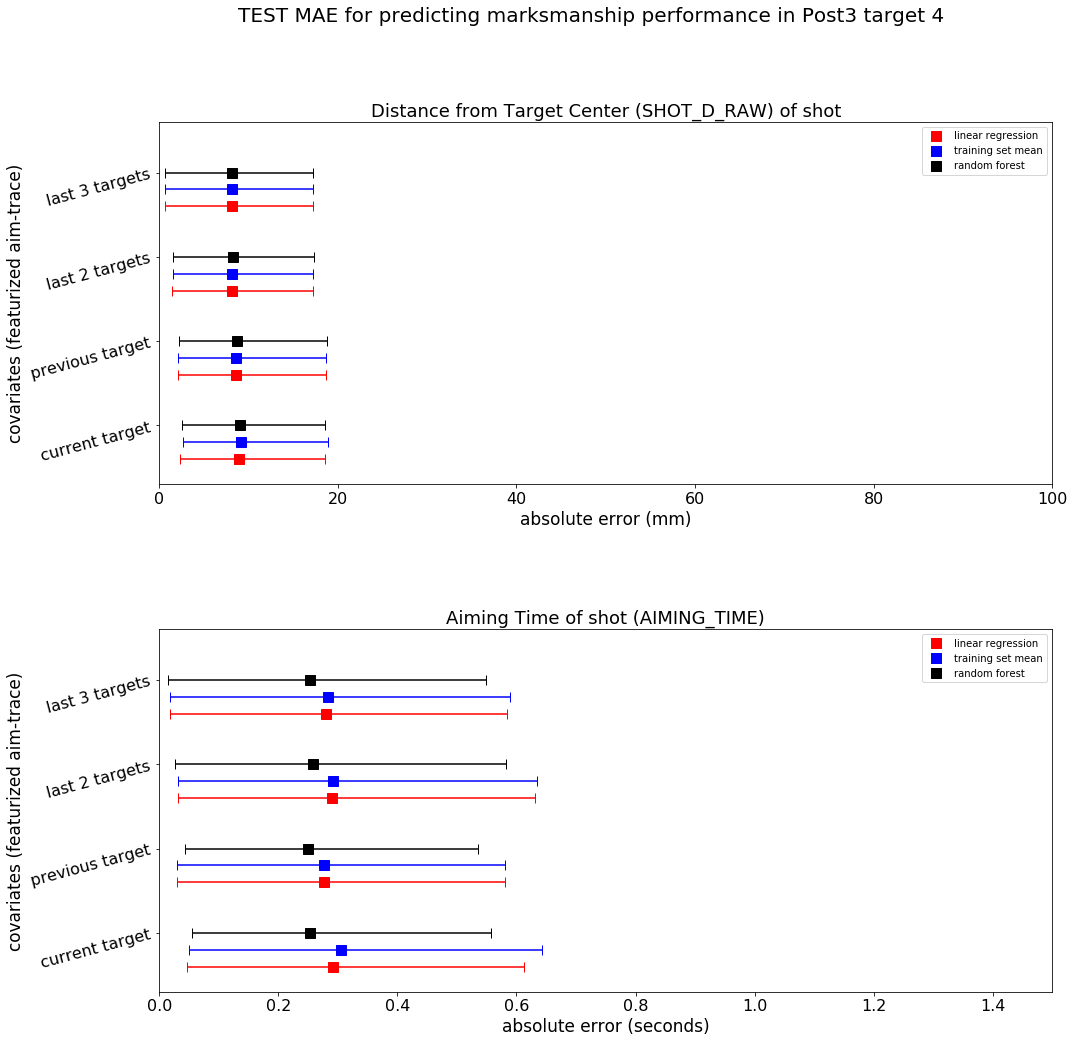

In [23]:
labels = summary_perf_df.covariate.unique()
better_labels_dict = dict.fromkeys(labels)
better_labels_dict['4 sessions_POST3'] = 'current target'
better_labels_dict['3 sessions_POST3'] = 'previous target'
better_labels_dict['2+3 sessions_POST3'] = 'last 2 targets'
better_labels_dict['1+2+3 sessions_POST3'] = 'last 3 targets'
better_labels_dict['1+2+3 sessions_all'] = 'last 3 targets all sessions'
better_labels_dict['1+2+3+4 sessions_all'] = 'all targets all sessions'

fontsize = 16
model_colors = ['r', 'b', 'k']
for error in ['test_mae']:
    f,axs = plt.subplots(len(y_factors),1)
    for ax_idx, y_factor in enumerate(y_factors):
        for p, model in enumerate(models):
            
            y = np.asarray(range(len(labels))) + p*0.2
            x = np.asarray(summary_perf_df.loc[(summary_perf_df.y_column==y_factor)&
                                    (summary_perf_df.percentile_across_trials==50)&
                                               (summary_perf_df.model==model), error])

            x_err_l = np.asarray(summary_perf_df.loc[(summary_perf_df.y_column==y_factor)&
                                    (summary_perf_df.percentile_across_trials==5)&
                                                     (summary_perf_df.model==model), error])

            x_err_u = np.asarray(summary_perf_df.loc[(summary_perf_df.y_column==y_factor)&
                                    (summary_perf_df.percentile_across_trials==95)&
                                                     (summary_perf_df.model==model), error])
            x_err = np.concatenate((x_err_l.reshape(-1,1), x_err_u.reshape(-1,1)), axis=1).T

            axs[ax_idx].errorbar(x=x, y=y, xerr=x_err, color=model_colors[p], capsize=5,
                                 linestyle="None",marker="s", markersize=10, label = model)
            axs[ax_idx].set_ylim([-.3,4])
            axs[ax_idx].set_yticks(y)
            axs[ax_idx].set_yticklabels([better_labels_dict[i] for i in labels], rotation=15)
#             axs[ax_idx].set_title(y_factor.upper(), fontsize=fontsize+2)
            err_aka = error.replace('_', ' ').upper()
            
            if y_factor=='shot_d_raw':
                axs[ax_idx].set_xlim([0, 100])
                axs[ax_idx].set_xlabel('absolute error (mm)', fontsize=fontsize+1)
                axs[ax_idx].set_title('Distance from Target Center (%s) of shot'%y_factor.upper(), fontsize=fontsize+2)
            elif y_factor=='aiming_time':
                axs[ax_idx].set_xlim([0, 1.5])
                axs[ax_idx].set_xlabel('absolute error (seconds)', fontsize=fontsize+1)
                axs[ax_idx].set_title('Aiming Time of shot (%s)'%y_factor.upper(), fontsize=fontsize+2)
                
            axs[ax_idx].set_ylabel('covariates (featurized aim-trace)', fontsize=fontsize+1)
            axs[ax_idx].legend(loc='upper right')
            axs[ax_idx].tick_params(axis="both", labelsize=fontsize)
#             axs[ax_idx].yaxis.set_label_position("right") 
        
#         plt.tick_params(axis='both', which='minor', labelsize=fontsize)
        plt.suptitle('%s for predicting marksmanship performance in Post3 target 4'%err_aka, fontsize=fontsize+4)
        plt.subplots_adjust(hspace=0.4)
        f.set_size_inches(16, 16)
        f.savefig('%s-shot-level.png'%error, bbox_inches='tight')
plt.show()

In [ ]:
summary_perf_df[(summary_perf_df.y_column==y_factor)&
                                    (summary_perf_df.percentile_across_trials==50)&
                                               (summary_perf_df.model==model)
               ]

In [ ]:
ticklabels = [item.get_text() for item in axs[ax_idx].get_yticklabels()]
ticklabels

## Old code

In [ ]:
n_trials = 10
n_cv_folds = 10
perc_vals = [5, 50, 95]

# Get the aim trace data in post 3 last target
targets_list = ['4 sessions_POST3', '3 sessions_POST3', '2+3 sessions_POST3', '1+2+3 sessions_POST3',
                '1+2+3 sessions_all', '1+2+3+4 sessions_all']
collapse_fns =['min', 'max', 'std', 'slope', 'skew']
high_freq_cols = ['shot_x_75', 'shot_y_75', 'shot_x_150', 'shot_y_150', 'aiming_time']
t_col = ['hours_from_shot_0']
id_cols = ['subject_uid', 'mission_phase', 'target_id']
row_df_list = list()
y_factors = ['lethality', 'mobility']
# perform linear regression to predict performance on last target adding aim trace 
# covariates from prev. sessions in every loop
for targets in targets_list:
    targets_sessions = targets.split(' ')
    sessions = targets_sessions[1].split('_')[1]
    target_ids = targets_sessions[0].split('+')
    
    if sessions == 'all':
        x_df = highfreq_df[(highfreq_df.target_id.isin(target_ids))].copy().reset_index(drop=True)
        y_df = target_outcomes_df[(target_outcomes_df.target_id.isin(target_ids))].copy().reset_index(drop=True)
        
    else:
        x_df = highfreq_df[(highfreq_df.mission_phase==sessions)&
                           (highfreq_df.target_id.isin(target_ids))].copy().reset_index(drop=True)
        y_df = target_outcomes_df[(target_outcomes_df.mission_phase==sessions)&
                                  (target_outcomes_df.target_id.isin(target_ids))].copy().reset_index(drop=True)
    
    subject_uids = list(set(x_df.subject_uid) & set(y_df.subject_uid))

    x_df = x_df[x_df.subject_uid.isin(subject_uids)].copy().reset_index(drop=True)
    y_df = y_df[y_df.subject_uid.isin(subject_uids)].copy().reset_index(drop=True)
    x_df.sort_values(by=id_cols, inplace=True)
    
    # create all zero vector as covariates so that prediction on test set is just the mean of training labels
    x_dummy_all_zero = np.zeros((y_df.shape[0], 1), dtype=np.float64)
    perc_vals = [5, 50, 95]
    
    # get fenceposts of per subject per target
    fp = get_fenceposts(x_df, id_cols)
    nrows = len(fp)-1
    ncols = len(high_freq_cols)*len(collapse_fns)
    x_collapsed = np.zeros((nrows, ncols))
    
    for p in range(nrows):
        fp_start = fp[p]
        fp_end = fp[p+1]
        x_vals = x_df.iloc[fp_start:fp_end, :][high_freq_cols].values
        t_vals = x_df.iloc[fp_start:fp_end, :][t_col].values

        for fn_ind, fn in enumerate(collapse_fns):
            col_start = fn_ind*len(high_freq_cols)
            col_end = (fn_ind+1)*len(high_freq_cols)
            x_collapsed[p, col_start : col_end] = collapse_fns_dict[fn](x=x_vals, t=t_vals)
    
    # run regression multi train test splits   
    for y_factor in y_factors:
        y = np.asarray(y_df[y_factor], dtype=np.float64).reshape(-1,1)
        for X , y, nickname in [(x_dummy_all_zero, y, 'mean_post3_target_4'), (x_collapsed, y, 'target%s'%targets)]:
            print('Predicting %s with %s as predictors'%(y_factor, nickname))
            
            nan_output_inds = np.isnan(y)[:,0]
            X = X[~nan_output_inds, :]
            y = y[~nan_output_inds, :]
            best_regressors, outer_perf_df, inner_perf_df_list = lasso_regression_multi_train_test_splits(X, y, 
                                                                                                          n_trials, n_cv_folds,
                                                                                                          gridsearchvalues__alpha=np.logspace(-12, 6, 37),
                                                                                                          x_feature_transform='standardize',
                                                                                                          scoring_metric='mean_absolute_error')

            for perc in perc_vals:
                row_df = pd.DataFrame(
                    [np.percentile(outer_perf_df.values[:, 1:], perc, axis=0)],
                    columns=outer_perf_df.columns[1:])
                row_df.insert(0, 'y_column', y_factor)
                row_df.insert(1, 'covariates_nickname', nickname)
                row_df.insert(2, 'n_features', X.shape[1])
                row_df.insert(3, 'percentile_across_trials', perc)
                row_df_list.append(row_df)
summary_perf_df = pd.concat(row_df_list, ignore_index=True)        
summary_perf_df.drop_duplicates(subset=['y_column', 'covariates_nickname', 'percentile_across_trials'], inplace=True)

In [ ]:
labels = summary_perf_df.covariates_nickname.unique()

for error in ['test_mae', 'test_mse']:
    f,axs = plt.subplots(2,1)
    for ax_idx, y_factor in enumerate(y_factors):
        x = np.asarray(range(len(labels)))/2
        y = np.asarray(summary_perf_df.loc[(summary_perf_df.y_column==y_factor)&
                                (summary_perf_df.percentile_across_trials==50), error])

        y_err_l = np.asarray(summary_perf_df.loc[(summary_perf_df.y_column==y_factor)&
                                (summary_perf_df.percentile_across_trials==5), error])

        y_err_u = np.asarray(summary_perf_df.loc[(summary_perf_df.y_column==y_factor)&
                                (summary_perf_df.percentile_across_trials==95), error])
        y_err = np.concatenate((y_err_l.reshape(-1,1), y_err_u.reshape(-1,1)), axis=1).T

        axs[ax_idx].errorbar(x=x, y=y, yerr=y_err, color="black", capsize=5,
                             linestyle="None",marker="s", markersize=10, 
                             mfc="black", mec="black")
        axs[ax_idx].set_xlim([-.3,3.3])
        axs[ax_idx].set_xticks(x)
        axs[ax_idx].set_xticklabels(labels, rotation=15)
        axs[ax_idx].set_title(y_factor)
        err_aka = error.replace('_', ' ').upper()
        axs[ax_idx].set_ylabel(err_aka)
        axs[ax_idx].set_xlabel('covariates')
    
        plt.suptitle('%s for predicting marksmanship performance in Post3 target 4'%err_aka)
        plt.subplots_adjust(hspace=0.45)
        f.set_size_inches(16.5, 12.5)
        f.savefig('%s-target-level.png'%error)
plt.show()